In [142]:
import matplotlib.pyplot as plt
import numpy as np
import pickle as pkl
import scipy

axis_resolution = 0.5

In [143]:
empty_path = "/Users/shaysnyder/dev/VSA-OGM/vsa_ogm/experiments/logs/build_vsa_map0/observations/observation_86/obs_proc/numpy_arrays/empty_heatmaps.npy"
occ_path = "/Users/shaysnyder/dev/VSA-OGM/vsa_ogm/experiments/logs/build_vsa_map0/observations/observation_86/obs_proc/numpy_arrays/occupied_heatmaps.npy"

In [144]:
with open(occ_path, "rb") as f:
    occ_data = np.load(f, allow_pickle=True)

In [145]:
print(occ_data.shape)

(200, 200)


In [146]:
np.min(occ_data)

-0.5140016

In [147]:
occ_data = np.square(occ_data)

In [148]:
np.max(occ_data)

1.0

In [149]:
occ_data *= 255
occ_data = occ_data.astype(np.uint8)

In [150]:
from skimage.filters.rank import entropy
from skimage.morphology import disk, square
disk_size: float = 1

In [151]:
occ_entropy = entropy(occ_data, disk(4))

In [152]:
print(np.max(occ_entropy))
print(np.min(occ_entropy))

5.533077191053985
0.0


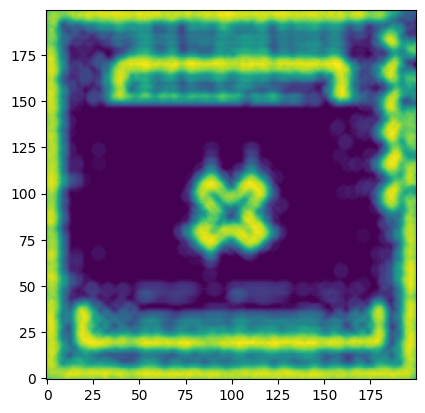

In [153]:
plt.imshow(occ_entropy, origin="lower")
plt.savefig("toysim-occ-entropy.png", dpi=500)

In [154]:
with open(empty_path, "rb") as f:
    empty_data = np.load(f, allow_pickle=True)

In [155]:
empty_data = np.square(empty_data)
empty_data *= 255
empty_data = empty_data.astype(np.uint8)

In [156]:
empty_entropy = entropy(empty_data, disk(10))

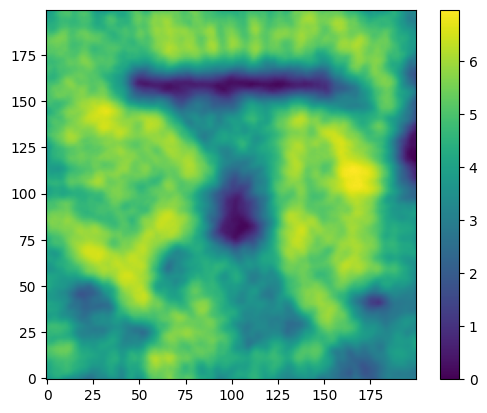

In [157]:
plt.imshow(empty_entropy, origin="lower")
plt.colorbar()
plt.savefig("toysim-empty-entropy.png", dpi=500)

In [158]:
print(np.max(empty_entropy))
print(np.min(empty_entropy))

6.96811447280546
0.0


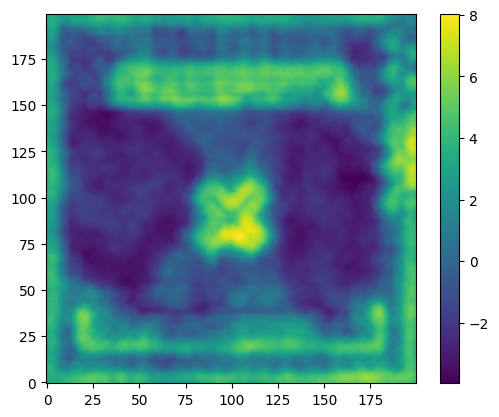

In [159]:
global_entropy = occ_entropy - empty_entropy + 3.0
plt.imshow(global_entropy, origin="lower")
plt.colorbar()
plt.savefig("toysim-global-entropy.png", dpi=500)

In [160]:
import os

BASE_CONFIG: dict = {
    "experiment_name": "build_vsa_map",
    "verbose": True,
    "data": {
        "dataset_name": "toysim", # toysim, intel
        "test_split": 0.1,
        "toysim": {
            "data_dir": os.path.expanduser("~") + "/dev/VSA-OGM/datasets/single/toysim0/npz",
            "file_prefix": "results_frame_",
            "file_suffix": ".npz",
            "world_bounds": [-50, 50, -50, 50] # x_min, x_max, y_min, y_max; meters
        },
        "intel": {
            "data_dir": os.path.expanduser("~") + "/dev/highfrost/highfrost/ogm/datasets/single/intel.csv",
            "world_bounds": [-20, 20, -25, 15] # x_min, x_max, y_min, y_max; meters
        },
    },
    "logging": {
        "log_dir": os.path.expanduser("~") + "/dev/VSA-OGM/vsa_ogm/experiments/logs",
        "occupied_map_dir": "occupied_maps",
        "empty_map_dir": "empty_maps",
        "global_maps_dir": "global_maps",
        "run_time_metrics": "run_time_metrics.pkl"
    }
}

import vsa_ogm.dataloaders.functional as hogmf
from omegaconf import DictConfig

config: DictConfig = DictConfig(BASE_CONFIG)

In [161]:
dataloader, world_size = hogmf.load_single_data(config)

# output = dataloader.reset()
# num_correct: int = 0
# num_total: int = 0

# plt.clf()

# for i in range(dataloader.max_steps()):
    
#     points = output["lidar_data"]
#     labels = output["occupancy"]

#     points[:, 0] -= world_size[0]
#     points[:, 1] -= world_size[2]

#     points /= axis_resolution

#     points = points.astype(np.uint8)

#     # m1 = points[:, 0] <= 199
#     # m2 = points[:, 1] <= 199
#     # m3 = np.logical_and(m1, m2)

#     # points = points[m3, :]
#     # labels = labels[m3]

#     occ_values = occ_entropy[points[:, 1], points[:, 0]]
#     empty_values = empty_entropy[points[:, 1], points[:, 0]]

#     preds = np.zeros(shape=(points.shape[0]))
#     preds[occ_values > empty_values] = 1
#     preds[occ_values <= empty_values] = 0

#     num_total += points.shape[0]
#     num_correct += points[preds == labels].shape[0]

#     plt.scatter(points[:, 0], points[:, 1], c=preds, s=1)
    
#     output = dataloader.step()

# print(num_correct / num_total)
# plt.savefig("toysim-preds.png", dpi=500)

In [162]:
import numpy as np
from sklearn import metrics

from vsa_ogm.metrics import calculate_multiple_TP_FP_rates
from vsa_ogm.plotting import plot_AUC

In [163]:
print(f"Occupied Entropy Max: {np.max(occ_entropy)}")
print(f"Occupied Entropy Min: {np.min(occ_entropy)}")
print(f"Empty Entropy Min: {np.min(empty_entropy)}")
print(f"Empty Entropy Max: {np.max(empty_entropy)}")

Occupied Entropy Max: 5.533077191053985
Occupied Entropy Min: 0.0
Empty Entropy Min: 0.0
Empty Entropy Max: 6.96811447280546


In [164]:
global_entropy2 = occ_entropy - empty_entropy
print(f"Global Entropy Max: {np.max(global_entropy2)}")
print(f"Global Entropy Min: {np.min(global_entropy2)}")

Global Entropy Max: 5.038164615314603
Global Entropy Min: -6.9588944919407885


In [165]:
threshold_min = np.min(global_entropy2)
threshold_max = np.max(global_entropy2)
threshold_step_size = 0.01
threshold_range = np.arange(threshold_min, threshold_max, threshold_step_size)
print(f"Num Threshold Steps: {threshold_range.shape[0]}")

Num Threshold Steps: 1200


Text(0, 0.5, 'Threshold Values')

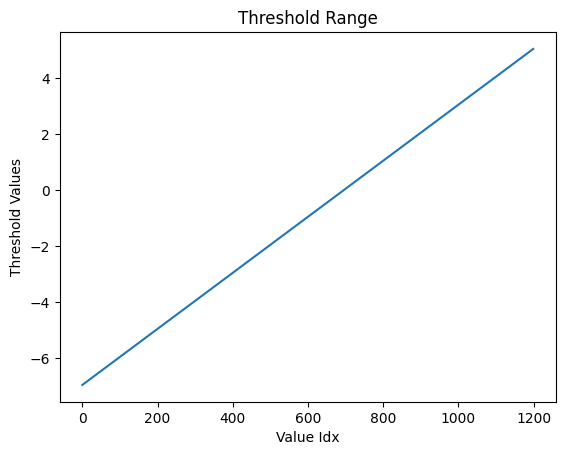

In [166]:
plt.plot(threshold_range)
plt.title("Threshold Range")
plt.xlabel("Value Idx")
plt.ylabel("Threshold Values")

In [167]:
def calculate_preds_w_threshold(ge: np.ndarray, threshold: float):
    output = dataloader.reset()

    labels_gt: list[np.ndarray] = []
    preds_list: list[np.ndarray] = []

    for i in range(dataloader.max_steps())[:-2]:
        
        points = output["lidar_data"]
        labels = output["occupancy"]

        points = points[points[:,0] >= world_size[0], :]
        points = points[points[:,0] <= world_size[1], :]
        points = points[points[:,1] >= world_size[2], :]
        points = points[points[:,1] <= world_size[3], :]
        labels = labels[points[:,0] >= world_size[0]]
        labels = labels[points[:,0] <= world_size[1]]
        labels = labels[points[:,1] >= world_size[2]]
        labels = labels[points[:,1] <= world_size[3]]  

        assert points.shape[0] == labels.shape[0]
        assert points.shape[0] > 0

        points[:, 0] -= world_size[0]
        points[:, 1] -= world_size[2]
        points /= axis_resolution
        points = points.astype(np.uint8)

        assert points.shape[0] == labels.shape[0]
        assert points.shape[0] > 0

        e_values = ge[points[:, 1], points[:, 0]]

        assert e_values.shape[0] == points.shape[0]
        
        preds = np.zeros(shape=(points.shape[0]))
        preds[e_values > threshold] = 1

        assert preds.shape[0] == points.shape[0]

        labels_gt.append(labels)
        preds_list.append(preds)
        
        output = dataloader.step()

    return np.concatenate(labels_gt), np.concatenate(preds_list)

In [127]:
y_true: list[np.ndarray] = []
y_pred: list[np.ndarray] = []

for t in threshold_range:
    true, pred = calculate_preds_w_threshold(global_entropy2, t)
    
    y_true.append(true)
    y_pred.append(pred)

In [128]:
tpr_list, fpr_list = calculate_multiple_TP_FP_rates(y_true, y_pred)

In [129]:
auc = metrics.auc(fpr_list, tpr_list)

In [130]:
auc

0.9638218952713064

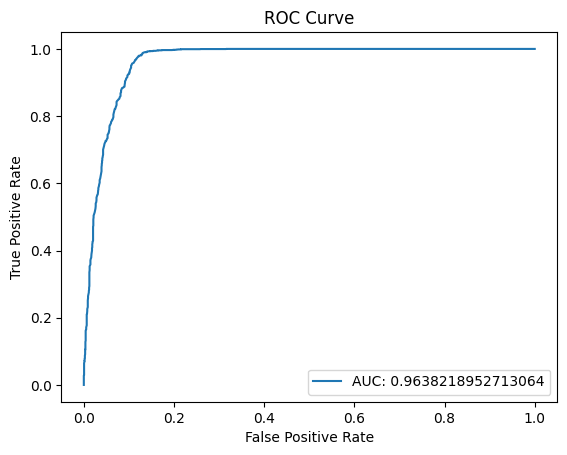

In [131]:
plt.plot(fpr_list, tpr_list, label=f"AUC: {auc}")
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.savefig("toysim-roc-curve.png", dpi=500)

In [132]:
with open("/Users/shaysnyder/dev/VSA-OGM/vsa_ogm/experiments/logs/test_data.pkl", "rb") as f:
    test_data = pkl.load(f)

In [133]:
test_data.keys()
assert len(test_data["lidar_data"]) == len(test_data["occupancy"])
len(test_data["lidar_data"][::2])

87

In [134]:
def calculate_preds_w_threshold_test(ge: np.ndarray, threshold: float, dataset):
    
    lidar_data = dataset["lidar_data"][::2]
    occupancy = dataset["occupancy"][::2]

    labels_gt: list[np.ndarray] = []
    preds_list: list[np.ndarray] = []

    for i in range(len(lidar_data)):
        
        points = lidar_data[i]
        labels = occupancy[i]

        points = points[points[:,0] >= world_size[0], :]
        points = points[points[:,0] <= world_size[1], :]
        points = points[points[:,1] >= world_size[2], :]
        points = points[points[:,1] <= world_size[3], :]
        labels = labels[points[:,0] >= world_size[0]]
        labels = labels[points[:,0] <= world_size[1]]
        labels = labels[points[:,1] >= world_size[2]]
        labels = labels[points[:,1] <= world_size[3]]  

        assert points.shape[0] == labels.shape[0]
        assert points.shape[0] > 0

        points[:, 0] -= world_size[0]
        points[:, 1] -= world_size[2]
        points /= axis_resolution
        points = points.astype(np.uint8)

        assert points.shape[0] == labels.shape[0]
        assert points.shape[0] > 0

        e_values = ge[points[:, 1], points[:, 0]]

        assert e_values.shape[0] == points.shape[0]
        
        preds = np.zeros(shape=(points.shape[0]))
        preds[e_values > threshold] = 1

        assert preds.shape[0] == points.shape[0]

        labels_gt.append(labels)
        preds_list.append(preds)

    return np.concatenate(labels_gt), np.concatenate(preds_list)

In [135]:
y_true: list[np.ndarray] = []
y_pred: list[np.ndarray] = []

for t in threshold_range:
    true, pred = calculate_preds_w_threshold_test(global_entropy2, t, test_data)
    
    y_true.append(true)
    y_pred.append(pred)

In [136]:
tpr_list, fpr_list = calculate_multiple_TP_FP_rates(y_true, y_pred)

In [137]:
auc = metrics.auc(fpr_list, tpr_list)

In [138]:
auc

0.9564332428704898

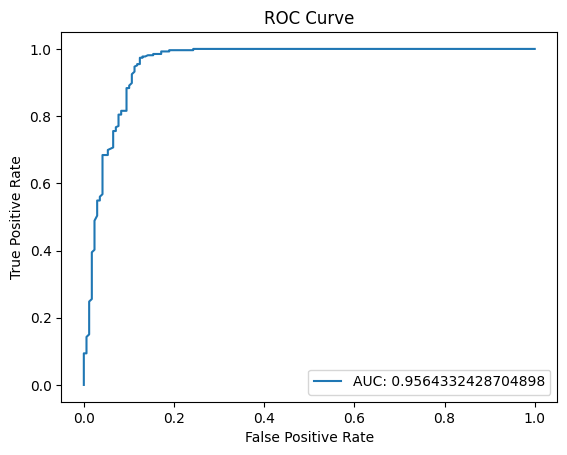

In [139]:
plt.plot(fpr_list, tpr_list, label=f"AUC: {auc}")
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.savefig("toysim-roc-curve.png", dpi=500)

In [140]:
from sklearn.metrics import f1_score, precision_score, recall_score
labels, preds = calculate_preds_w_threshold_test(global_entropy, -0.9, test_data)

In [141]:
print(f"F1 Score: {f1_score(labels, preds)}")
print(f"Precision: {precision_score(labels, preds)}")
print(f"Recall: {recall_score(labels, preds)}")

F1 Score: 0.8764415156507414
Precision: 0.7800586510263929
Recall: 1.0
